## mini-ImageNet
### Create a directory to store mini-ImageNet data and results.

In [1]:
!mkdir -p mini_imagenet
!mkdir -p mini_imagenet/data
data_dir = "mini_imagenet/data"

/bin/bash: /home/atik/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/atik/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
!mv $data_dir/mini-imagenet-cache-train.pkl $data_dir/train.pkl
!mv $data_dir/mini-imagenet-cache-val.pkl $data_dir/valid.pkl
!mv $data_dir/mini-imagenet-cache-test.pkl $data_dir/test.pkl

/bin/bash: /home/atik/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat 'mini_imagenet/data/mini-imagenet-cache-train.pkl': No such file or directory
/bin/bash: /home/atik/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat 'mini_imagenet/data/mini-imagenet-cache-val.pkl': No such file or directory
/bin/bash: /home/atik/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat 'mini_imagenet/data/mini-imagenet-cache-test.pkl': No such file or directory


### Import

In [18]:
import pickle
import cv2
import numpy as np

from tqdm.notebook import trange, tqdm

### Function to load images and their labels from a pkl file.

In [19]:
# file_name -> path + name of the file
def load_images(file_name):
    # get file content
    with open(file_name, 'rb') as f:
        info = pickle.load(f)

    img_data = info['image_data']
    class_dict = info['class_dict']

    # create arrays to store x and y of images
    images = [] # x
    labels = [] # y
  
    # loop over all images and store them
    loading_msg = 'Reading images from %s' % file_name

    # loop over all classes
    for item in tqdm(class_dict.items(), desc = loading_msg):
        # loop over all examples from the class
        for example_num in item[1]:
            # convert image to RGB color channels
            RGB_img = cv2.cvtColor(img_data[example_num], cv2.COLOR_BGR2RGB)

            # store image and corresponding label
            images.append(RGB_img)
            labels.append(item[0])
  
    # return set of images
    return np.array(images), np.array(labels)

### Import some modules.

In [5]:
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt

### Function to generate one episode.

In [6]:
# img_set_x -> images
# img_set_y -> labels
# num_way -> number of classes for episode
# num_shot -> number of examples per class
# num_query -> number of query examples per class 
def extract_episode(img_set_x, img_set_y, num_way, num_shot, num_query):
    # get a list of all unique labels (no repetition)
    unique_labels = np.unique(img_set_y)

    # select num_way classes randomly without replacement
    chosen_labels = np.random.choice(unique_labels, num_way, replace = False)
    # number of examples per selected class (label)
    examples_per_label = num_shot + num_query

    # list to store the episode
    episode = []

    # iterate over all selected labels 
    for label_l in chosen_labels:
        # get all images with a certain label l
        images_with_label_l = img_set_x[img_set_y == label_l]

        # suffle images with label l
        shuffled_images = np.random.permutation(images_with_label_l)

        # chose examples_per_label images with label l
        chosen_images = shuffled_images[:examples_per_label]

        # add the chosen images to the episode
        episode.append(chosen_images)

    # turn python list into a numpy array
    episode = np.array(episode)

    # convert numpy array to tensor of floats
    episode = torch.from_numpy(episode).float()

    # reshape tensor (required)
    episode = episode.permute(0,1,4,2,3)

    # get the shape of the images
    img_dim = episode.shape[2:]
  
    # build a dict with info about the generated episode
    episode_dict = {
        'images': episode, 'num_way': num_way, 'num_shot': num_shot, 
        'num_query': num_query, 'img_dim': img_dim}

    return episode_dict

### Function to display a grid representation of an episode.

In [7]:
# episode_dict -> dict with info about the chosen episode
def display_episode_images(episode_dict):
    # number of examples per class 
    examples_per_label = episode_dict['num_shot'] + episode_dict['num_query']

    # total number of images
    num_images = episode_dict['num_way'] * examples_per_label

    # select the images
    images = episode_dict['images'].view(num_images, *episode_dict['img_dim'])

    # create a grid with all the images
    grid_img = torchvision.utils.make_grid(images, nrow = examples_per_label)

    # reshape the tensor and convert to numpy array of integers 
    grid_img = grid_img.permute(1, 2, 0).numpy().astype(np.uint8)

    # chage image from BGR to RGB
    grid_img = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)

    # set a bigger size
    plt.figure(figsize = (80, 8))

    # remove the axis
    plt.axis('off')

    # plot the grid image
    plt.imshow(grid_img)

## Utility Functions

### Import required modules.


In [8]:
import logging
import sys

from os import path, mkdir, remove

### Function to calculate the euclidean distance between embeddings.

In [9]:
def euclidean_dist(x, y):
    elements_in_x = x.size(0)
    elements_in_y = y.size(0)

    dimension_elements = x.size(1)

    assert dimension_elements == y.size(1)

    x = x.unsqueeze(1).expand(elements_in_x , elements_in_y, dimension_elements)
    y = y.unsqueeze(0).expand(elements_in_x , elements_in_y, dimension_elements)

    distances = torch.pow(x - y, 2).sum(2)

    return distances

### Logger

In [10]:
console_logging_format = "%(message)s"

logging.basicConfig(stream = sys.stdout, level = logging.INFO, format = console_logging_format)

print(logging.getLogger().handlers)

[<StreamHandler stdout (NOTSET)>]


In [11]:
def create_logger(log_dir, file_name):
    # get logger
    logger = logging.getLogger()
    
    # remove previous handlers, if they exist
    if bool(logger.handlers):
        logger.handlers.clear()
    
    # create a log directory, if not exists
    if not path.exists(log_dir):
        mkdir(log_dir)
    
    log_file_path = path.join(log_dir, file_name)
    
    # remove old log file (w/ same name)
    if path.exists(log_file_path):
        remove(log_file_path)
    
    # create a new log file
    f = open(log_file_path, 'w+')
    f.close()

    # create a file handler for output file
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.INFO)
    
    # configure message to log in file
    file_logging_format = "[%(levelname)s] %(asctime)s: %(message)s"
    formatter = logging.Formatter(file_logging_format)
    file_handler.setFormatter(formatter)
    
    # create a console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    
    # configure message to log in console
    console_logging_format = "%(message)s"
    formatter = logging.Formatter(console_logging_format)
    console_handler.setFormatter(formatter)
    
    # add handlers to logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

## Model
### Import required modules.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

### The model below computes a class prototype by averaging the support embeddings of a class.

In [13]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, episode_dict):
        # extract all images 
        images = episode_dict['images'].cuda()
        
        # get episode setup
        num_way = episode_dict['num_way'] # way
        num_shot = episode_dict['num_shot'] # shot
        num_query = episode_dict['num_query'] # number of query images
        
        # from each class, extract num_shot support images
        x_support = images[:, :num_shot] # lines are classes and columns are images
        
        # from each class, extract the remaining images as query images
        x_query = images[:, num_shot:] # lines are classes and columns are images
        
        # create indices from 0 to num_way-1 for classification
        target_inds = torch.arange(0, num_way).view(num_way, 1, 1)
        
        # replicate all indices num_query times (for each query image)
        target_inds = target_inds.expand(num_way, num_query, 1).long()
        
        # convert indices from Tensor to Variable
        target_inds = Variable(target_inds, requires_grad = False).cuda()
        
        # transform x_support into a array in which all images are contiguous
        x_support = x_support.contiguous().view(
            num_way * num_shot, *x_support.size()[2:]) # no more lines and columns
                
        # transform x_query into a array in which all images are contiguous
        x_query = x_query.contiguous().view(
            num_way * num_query, *x_query.size()[2:]) # no more lines and columns

        # join all images into a single contiguous array 
        x = torch.cat([x_support, x_query], 0)
        
        # encode all images
        z = self.encoder.forward(x) # embeddings
        
        # compute class prototypes
        z_dim = z.size(-1)
        z_proto = z[:(num_way * num_shot)].view(num_way, num_shot, z_dim).mean(1)
        
        # get the query embeddings
        z_query = z[(num_way * num_shot):]

        # compute distance between query embeddings and class prototypes
        dists = euclidean_dist(z_query, z_proto)
        
        # compute the log probabilities
        log_p_y = F.log_softmax(-dists, dim = 1).view(num_way, num_query, -1)
        
        # compute the loss
        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        
        # get the predicted labels for each query
        _, y_hat = log_p_y.max(2) # lines are classes and columns are query embeddings
        
        # compute the accuracy
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
        
        # return output: loss, acc and predicted value
        return loss_val, {
            'loss': loss_val.item(), 'acc': acc_val.item(), 'y_hat': y_hat}

### Function to load the model.

In [14]:
# function to load the model structure
def load_protonet(x_dim, hid_dim, z_dim):
    # define a convolutional block
    def conv_block(layer_input, layer_output): 
        conv = nn.Sequential(
            nn.Conv2d(layer_input, layer_output, 3, padding=1),
            nn.BatchNorm2d(layer_output), nn.ReLU(), 
            nn.MaxPool2d(2))

        return conv
  
    # create the encoder to the embeddings for the images
    # the encoder is made of four conv blocks 
    encoder = nn.Sequential(
        conv_block(x_dim[0], hid_dim), conv_block(hid_dim, hid_dim), 
        conv_block(hid_dim, hid_dim), conv_block(hid_dim, z_dim), Flatten())
  
    return ProtoNet(encoder)

## For training and evaluating

### Import required modules.

In [15]:
import torch.nn as nn
import torch.optim as optim

import numpy as np
from math import fsum

from tqdm.notebook import trange
from os import path, mkdir

In [20]:
# Options: "omniglot" or "mini_imagenet"
dataset = "mini_imagenet"

In [21]:
data_dir = path.join(dataset, 'data')

train_x, train_y = load_images(path.join(data_dir,  'train.pkl'))
valid_x, valid_y = load_images(path.join(data_dir,  'valid.pkl'))
test_x, test_y = load_images(path.join(data_dir,  'test.pkl'))

Reading images from mini_imagenet/data/train.pkl:   0%|          | 0/64 [00:00<?, ?it/s]

Reading images from mini_imagenet/data/valid.pkl:   0%|          | 0/16 [00:00<?, ?it/s]

Reading images from mini_imagenet/data/test.pkl:   0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(38400, 84, 84, 3) (38400,)
(9600, 84, 84, 3) (9600,)
(12000, 84, 84, 3) (12000,)


### Generate and display an episode to check if everything is okay.

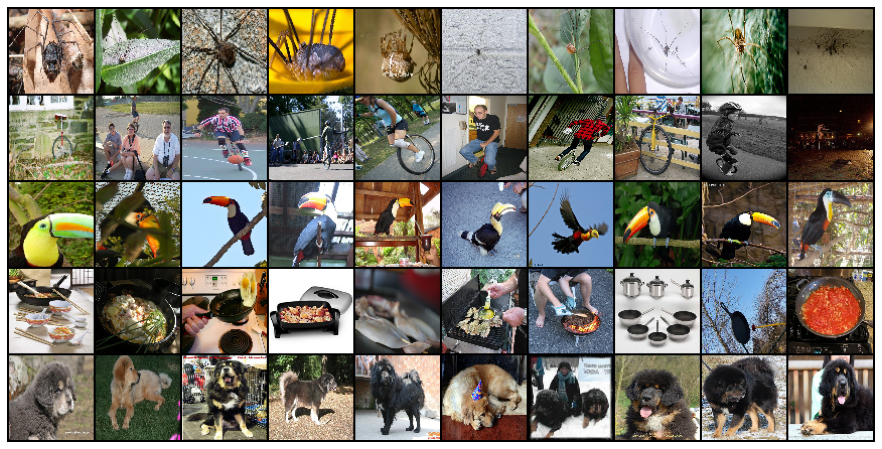

In [37]:
episode_dict = extract_episode(train_x, train_y, num_way = 5, num_shot = 5, num_query = 5)
display_episode_images(episode_dict)

### Create a directory to store the time of execution and the results.

In [38]:
results_dir = path.join(dataset, 'results')

if not path.exists(results_dir):
    mkdir(results_dir)

### Set hyperparameters and other parameters.

In [40]:
best_epoch = {
    'number': -1,
    'loss': np.inf,
    'acc': 0}

config = {
    'results_dir': results_dir,
    'learning_rate': 0.001,
    'decay_every': 20,
    'patience': 100,
    'best_epoch': best_epoch,
    'wait': 0,
    'stop': False}

### Load model structure.

In [41]:
# images have 3 color channels and are 84 x 84
# Convolutional blocks have 64 filters
model = load_protonet(x_dim  = (3, 84, 84), hid_dim = 64, z_dim = 64)

## Train and evaluate

### Function to train the model on the train set through many epochs.

### At the end of each epoch, the model is evaluated on the validation set.


In [42]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# train_data -> train set, num_way, num_shot, num_query etc
# valid_data -> validation set, num_way, num_shot, num_query etc
def train(model, config, train_data, valid_data, logger):
    # set Adam optimizer with an initial learning rate
    optimizer = optim.Adam(
        model.parameters(), lr = config['learning_rate'])

    # schedule learning rate to be cut in half every 2000 episodes
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, config['decay_every'], gamma = 0.5, last_epoch = -1)

    # set model to training mode
    model.train()

    # number of epochs so far
    epochs_so_far = 0

    # train until early stopping says so
    # or until the max number of epochs is not achived 
    while epochs_so_far < train_data['max_epoch'] and not config['stop']:
        epoch_loss = 0.0
        epoch_acc = 0.0

        logger.info('==> Epoch %d' % (epochs_so_far + 1))

        logger.info('> Training')

        # do epoch_size classification tasks to train the model
        for episode in trange(train_data['epoch_size']):
            # get the episode dict
            episode_dict = extract_episode(
              train_data['train_x'], train_data['train_y'], train_data['num_way'], 
              train_data['num_shot'], train_data['num_query'])

            optimizer.zero_grad()

            # classify images and get the loss and the acc of the curr episode
            loss, output = model.set_forward_loss(episode_dict)

            # acumulate the loss and the acc
            epoch_loss += output['loss']
            epoch_acc += output['acc']

            # update the model parameters (weights and biases)
            loss.backward()
            optimizer.step()

        # average the loss and the acc to get the epoch loss and the acc
        epoch_loss = epoch_loss / train_data['epoch_size']
        epoch_acc = epoch_acc / train_data['epoch_size']

        # output the epoch loss and the epoch acc
        logger.info('Loss: %.4f / Acc: %.2f%%' % (epoch_loss, (epoch_acc * 100)))

        # do one epoch of evaluation on the validation test
        evaluate_valid(model, config, valid_data, epochs_so_far + 1, logger)

        # increment the number of epochs
        epochs_so_far += 1

        # tell the scheduler to increment its counter
        scheduler.step()

    # get dict with info about the best epoch
    best_epoch = config['best_epoch']

    # at the end of the training, output the best loss and the best acc
    logger.info('Best loss: %.4f / Best Acc: %.2f%%' 
          % (best_epoch['loss'], (best_epoch['acc'] * 100)))

    # save dict with info about the best epoch
    with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'wb') as f:
        pickle.dump(best_epoch, f, pickle.HIGHEST_PROTOCOL)

### Function to evaluate the model on the validation set.

In [43]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# valid_data -> validation set, num_way, num_shot, num_query etc
# epoch -> number of the respective training epoch
def evaluate_valid(model, config, valid_data, curr_epoch, logger):
    # set model to evaluation mode
    model.eval()

    valid_loss = 0.0
    valid_acc = 0.0

    logger.info('> Validation')

    # do epoch_size classification tasks to evaluate the model
    for episode in trange(valid_data['epoch_size']):
        # get the episode dict
        episode_dict = extract_episode(
            valid_data['valid_x'], valid_data['valid_y'], valid_data['num_way'], 
            valid_data['num_shot'], valid_data['num_query'])

        # classify images and get the loss and the acc of the curr episode
        _, output = model.set_forward_loss(episode_dict)

        # acumulate the loss and the acc
        valid_loss += output['loss']
        valid_acc += output['acc']
  
    # average the loss and the acc to get the valid loss and the acc
    valid_loss = valid_loss / valid_data['epoch_size']
    valid_acc = valid_acc / valid_data['epoch_size']

    # output the valid loss and the valid acc
    logger.info('Loss: %.4f / Acc: %.2f%%' % (valid_loss, (valid_acc * 100)))

    # implement early stopping mechanism
    # check if valid_loss is the best so far
    if config['best_epoch']['loss'] > valid_loss:
        # if true, save the respective train epoch
        config['best_epoch']['number'] = curr_epoch

        # save the best loss and the respective acc
        config['best_epoch']['loss'] = valid_loss
        config['best_epoch']['acc'] = valid_acc

        # save the model with the best loss so far
        model_file = path.join(config['results_dir'], 'best_model.pth')
        torch.save(model.state_dict(), model_file)

        logger.info('=> This is the best model so far! Saving...')

        # set wait to zero
        config['wait'] = 0
    else:
        # if false, increment the wait
        config['wait'] += 1

        # when the wait is bigger than the patience
        if config['wait'] > config['patience']:
            # the train has to stop
            config['stop'] = True

            logger.info('Patience was exceeded... Stopping...')

### Now, let's train the model.

In [44]:
if dataset == 'mini_imagenet':
    train_data = {
        'train_x': train_x,
        'train_y': train_y,
        'num_way': 20,
        'num_shot': 5,
        'num_query': 15,
        'max_epoch': 10000,
        'epoch_size': 100}
elif dataset == 'omniglot':
    train_data = {
        'train_x': train_x,
        'train_y': train_y,
        'num_way': 60,
        'num_shot': 5,
        'num_query': 5,
        'max_epoch': 10000,
        'epoch_size': 100}

valid_data = {
    'valid_x': valid_x,
    'valid_y': valid_y,
    'num_way': 5,
    'num_shot': 5,
    'num_query': 15,
    'epoch_size': 100}

train_logger = create_logger(path.join(dataset, 'logs'), 'train.log')

train_time = %timeit -n1 -r1 -q -o train(model, config, train_data, valid_data, train_logger)

train_logger.info('Time taken: ' + str(train_time))

==> Epoch 1
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 17.4201 / Acc: 20.21%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5546 / Acc: 40.09%
=> This is the best model so far! Saving...
==> Epoch 2
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.6109 / Acc: 23.98%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3377 / Acc: 45.97%
=> This is the best model so far! Saving...
==> Epoch 3
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.4563 / Acc: 26.38%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2706 / Acc: 48.19%
=> This is the best model so far! Saving...
==> Epoch 4
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.3718 / Acc: 29.36%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2313 / Acc: 50.53%
=> This is the best model so far! Saving...
==> Epoch 5
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.2932 / Acc: 30.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2080 / Acc: 51.68%
=> This is the best model so far! Saving...
==> Epoch 6
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.2389 / Acc: 32.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2083 / Acc: 51.27%
==> Epoch 7
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.2156 / Acc: 32.91%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1984 / Acc: 52.59%
=> This is the best model so far! Saving...
==> Epoch 8
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.1856 / Acc: 33.72%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1719 / Acc: 53.47%
=> This is the best model so far! Saving...
==> Epoch 9
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.1557 / Acc: 34.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1570 / Acc: 53.81%
=> This is the best model so far! Saving...
==> Epoch 10
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.1041 / Acc: 36.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1792 / Acc: 53.12%
==> Epoch 11
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.1265 / Acc: 35.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1165 / Acc: 54.80%
=> This is the best model so far! Saving...
==> Epoch 12
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0783 / Acc: 36.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1854 / Acc: 53.76%
==> Epoch 13
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0925 / Acc: 36.68%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1354 / Acc: 54.75%
==> Epoch 14
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0808 / Acc: 37.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1478 / Acc: 54.04%
==> Epoch 15
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0619 / Acc: 36.92%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1263 / Acc: 55.43%
==> Epoch 16
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0274 / Acc: 38.78%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1381 / Acc: 55.24%
==> Epoch 17
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0254 / Acc: 38.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1444 / Acc: 55.48%
==> Epoch 18
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.9853 / Acc: 39.21%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0987 / Acc: 56.45%
=> This is the best model so far! Saving...
==> Epoch 19
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.9726 / Acc: 39.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1063 / Acc: 55.64%
==> Epoch 20
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.9969 / Acc: 39.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1254 / Acc: 55.17%
==> Epoch 21
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8773 / Acc: 42.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0499 / Acc: 58.11%
=> This is the best model so far! Saving...
==> Epoch 22
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8603 / Acc: 42.39%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0366 / Acc: 58.81%
=> This is the best model so far! Saving...
==> Epoch 23
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8721 / Acc: 42.14%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0767 / Acc: 57.80%
==> Epoch 24
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8783 / Acc: 42.34%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0490 / Acc: 58.19%
==> Epoch 25
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8469 / Acc: 43.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0451 / Acc: 59.29%
==> Epoch 26
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8120 / Acc: 43.84%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0367 / Acc: 59.31%
==> Epoch 27
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8240 / Acc: 43.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0234 / Acc: 60.24%
=> This is the best model so far! Saving...
==> Epoch 28
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8156 / Acc: 44.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0240 / Acc: 59.88%
==> Epoch 29
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7995 / Acc: 44.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0422 / Acc: 58.57%
==> Epoch 30
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7911 / Acc: 44.68%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0006 / Acc: 61.05%
=> This is the best model so far! Saving...
==> Epoch 31
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7832 / Acc: 45.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0102 / Acc: 60.68%
==> Epoch 32
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7744 / Acc: 45.27%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0201 / Acc: 59.73%
==> Epoch 33
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7984 / Acc: 44.47%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0250 / Acc: 59.47%
==> Epoch 34
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7584 / Acc: 45.19%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0346 / Acc: 59.19%
==> Epoch 35
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7473 / Acc: 45.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0226 / Acc: 60.23%
==> Epoch 36
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7291 / Acc: 46.17%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0077 / Acc: 60.80%
==> Epoch 37
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7552 / Acc: 45.79%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0098 / Acc: 60.91%
==> Epoch 38
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7577 / Acc: 45.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0515 / Acc: 60.09%
==> Epoch 39
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7209 / Acc: 46.48%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0312 / Acc: 60.11%
==> Epoch 40
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7168 / Acc: 46.43%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0817 / Acc: 58.37%
==> Epoch 41
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6786 / Acc: 47.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9669 / Acc: 63.39%
=> This is the best model so far! Saving...
==> Epoch 42
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6451 / Acc: 48.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9915 / Acc: 61.24%
==> Epoch 43
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6454 / Acc: 48.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9900 / Acc: 61.29%
==> Epoch 44
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6393 / Acc: 48.48%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0134 / Acc: 60.89%
==> Epoch 45
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6475 / Acc: 48.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9966 / Acc: 61.29%
==> Epoch 46
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6136 / Acc: 49.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9389 / Acc: 63.35%
=> This is the best model so far! Saving...
==> Epoch 47
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6189 / Acc: 49.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9951 / Acc: 61.33%
==> Epoch 48
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6190 / Acc: 49.44%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0013 / Acc: 60.64%
==> Epoch 49
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6007 / Acc: 49.74%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9556 / Acc: 62.80%
==> Epoch 50
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6071 / Acc: 49.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9469 / Acc: 63.13%
==> Epoch 51
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6016 / Acc: 49.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9621 / Acc: 62.29%
==> Epoch 52
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5823 / Acc: 50.09%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9632 / Acc: 62.45%
==> Epoch 53
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6148 / Acc: 49.29%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9549 / Acc: 63.12%
==> Epoch 54
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5985 / Acc: 49.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9588 / Acc: 62.31%
==> Epoch 55
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5700 / Acc: 51.17%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9639 / Acc: 62.63%
==> Epoch 56
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5765 / Acc: 51.09%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9751 / Acc: 63.29%
==> Epoch 57
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5728 / Acc: 50.56%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9887 / Acc: 61.88%
==> Epoch 58
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5330 / Acc: 51.94%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0080 / Acc: 60.80%
==> Epoch 59
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5501 / Acc: 51.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9111 / Acc: 64.87%
=> This is the best model so far! Saving...
==> Epoch 60
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5098 / Acc: 52.23%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9463 / Acc: 62.36%
==> Epoch 61
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5020 / Acc: 52.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9199 / Acc: 64.44%
==> Epoch 62
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4984 / Acc: 52.51%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9603 / Acc: 62.40%
==> Epoch 63
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4608 / Acc: 53.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9577 / Acc: 63.04%
==> Epoch 64
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4570 / Acc: 53.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9360 / Acc: 63.99%
==> Epoch 65
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4675 / Acc: 53.54%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9355 / Acc: 63.71%
==> Epoch 66
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4889 / Acc: 52.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9278 / Acc: 64.39%
==> Epoch 67
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4600 / Acc: 53.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9227 / Acc: 64.09%
==> Epoch 68
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4668 / Acc: 53.12%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9288 / Acc: 63.97%
==> Epoch 69
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4473 / Acc: 54.21%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9410 / Acc: 64.88%
==> Epoch 70
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4761 / Acc: 52.96%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9195 / Acc: 63.76%
==> Epoch 71
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4831 / Acc: 52.71%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9450 / Acc: 62.60%
==> Epoch 72
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4394 / Acc: 54.18%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9482 / Acc: 63.41%
==> Epoch 73
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4314 / Acc: 54.92%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9569 / Acc: 62.83%
==> Epoch 74
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4581 / Acc: 53.63%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9071 / Acc: 65.31%
=> This is the best model so far! Saving...
==> Epoch 75
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4598 / Acc: 54.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9286 / Acc: 63.69%
==> Epoch 76
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4489 / Acc: 53.76%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9623 / Acc: 62.85%
==> Epoch 77
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4391 / Acc: 54.36%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9341 / Acc: 63.67%
==> Epoch 78
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4143 / Acc: 54.99%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9624 / Acc: 62.81%
==> Epoch 79
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4263 / Acc: 54.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9443 / Acc: 62.84%
==> Epoch 80
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4312 / Acc: 54.71%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9388 / Acc: 63.51%
==> Epoch 81
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4031 / Acc: 55.41%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9157 / Acc: 64.51%
==> Epoch 82
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3842 / Acc: 55.89%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9412 / Acc: 63.64%
==> Epoch 83
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3783 / Acc: 55.66%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9245 / Acc: 63.56%
==> Epoch 84
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3805 / Acc: 56.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9243 / Acc: 64.40%
==> Epoch 85
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3942 / Acc: 55.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8945 / Acc: 65.36%
=> This is the best model so far! Saving...
==> Epoch 86
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3603 / Acc: 56.41%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9650 / Acc: 62.65%
==> Epoch 87
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3757 / Acc: 56.34%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9095 / Acc: 64.51%
==> Epoch 88
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3801 / Acc: 55.81%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9424 / Acc: 63.56%
==> Epoch 89
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3843 / Acc: 55.81%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9069 / Acc: 64.75%
==> Epoch 90
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3692 / Acc: 55.91%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9380 / Acc: 64.29%
==> Epoch 91
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3508 / Acc: 56.66%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9648 / Acc: 62.39%
==> Epoch 92
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3630 / Acc: 56.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9101 / Acc: 65.55%
==> Epoch 93
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3639 / Acc: 56.14%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9330 / Acc: 63.88%
==> Epoch 94
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3370 / Acc: 56.92%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9340 / Acc: 63.59%
==> Epoch 95
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3579 / Acc: 56.57%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9291 / Acc: 64.12%
==> Epoch 96
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3491 / Acc: 56.92%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9132 / Acc: 64.09%
==> Epoch 97
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3224 / Acc: 57.59%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8737 / Acc: 65.71%
=> This is the best model so far! Saving...
==> Epoch 98
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3506 / Acc: 56.51%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9458 / Acc: 63.19%
==> Epoch 99
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3423 / Acc: 57.03%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9323 / Acc: 64.52%
==> Epoch 100
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3579 / Acc: 56.52%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9398 / Acc: 63.29%
==> Epoch 101
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3411 / Acc: 56.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8841 / Acc: 65.81%
==> Epoch 102
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3311 / Acc: 57.42%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9188 / Acc: 64.24%
==> Epoch 103
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3374 / Acc: 56.93%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9102 / Acc: 64.52%
==> Epoch 104
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3152 / Acc: 57.62%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9466 / Acc: 63.43%
==> Epoch 105
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3375 / Acc: 57.32%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9210 / Acc: 63.99%
==> Epoch 106
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3495 / Acc: 56.71%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9334 / Acc: 63.79%
==> Epoch 107
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3223 / Acc: 57.57%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9161 / Acc: 64.91%
==> Epoch 108
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3285 / Acc: 57.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9294 / Acc: 64.43%
==> Epoch 109
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3536 / Acc: 56.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9211 / Acc: 64.12%
==> Epoch 110
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3440 / Acc: 56.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9273 / Acc: 64.59%
==> Epoch 111
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3328 / Acc: 57.14%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9496 / Acc: 63.01%
==> Epoch 112
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3327 / Acc: 57.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8828 / Acc: 65.96%
==> Epoch 113
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3242 / Acc: 57.68%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9046 / Acc: 64.29%
==> Epoch 114
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3091 / Acc: 57.63%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8969 / Acc: 64.51%
==> Epoch 115
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3109 / Acc: 57.69%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9043 / Acc: 65.29%
==> Epoch 116
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3235 / Acc: 57.73%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9307 / Acc: 63.79%
==> Epoch 117
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2982 / Acc: 58.43%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9218 / Acc: 64.60%
==> Epoch 118
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3048 / Acc: 57.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9769 / Acc: 61.80%
==> Epoch 119
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2940 / Acc: 58.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9156 / Acc: 64.77%
==> Epoch 120
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2883 / Acc: 58.38%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9193 / Acc: 64.69%
==> Epoch 121
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3188 / Acc: 57.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9057 / Acc: 65.09%
==> Epoch 122
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2974 / Acc: 58.29%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8969 / Acc: 66.03%
==> Epoch 123
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3001 / Acc: 58.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9328 / Acc: 64.00%
==> Epoch 124
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2989 / Acc: 58.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9267 / Acc: 63.65%
==> Epoch 125
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2837 / Acc: 59.16%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9290 / Acc: 64.25%
==> Epoch 126
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3106 / Acc: 58.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8960 / Acc: 65.25%
==> Epoch 127
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3014 / Acc: 57.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9224 / Acc: 63.59%
==> Epoch 128
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2948 / Acc: 58.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9316 / Acc: 64.56%
==> Epoch 129
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2915 / Acc: 58.73%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9082 / Acc: 64.20%
==> Epoch 130
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3180 / Acc: 57.66%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9056 / Acc: 64.75%
==> Epoch 131
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2979 / Acc: 58.17%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9116 / Acc: 64.64%
==> Epoch 132
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3006 / Acc: 57.87%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8619 / Acc: 67.28%
=> This is the best model so far! Saving...
==> Epoch 133
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2908 / Acc: 58.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9166 / Acc: 64.73%
==> Epoch 134
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3167 / Acc: 58.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8863 / Acc: 65.27%
==> Epoch 135
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2958 / Acc: 58.59%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8945 / Acc: 65.37%
==> Epoch 136
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2868 / Acc: 58.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9382 / Acc: 63.97%
==> Epoch 137
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2812 / Acc: 58.39%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9431 / Acc: 63.08%
==> Epoch 138
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2970 / Acc: 58.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9105 / Acc: 64.48%
==> Epoch 139
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3056 / Acc: 58.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9248 / Acc: 64.83%
==> Epoch 140
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2837 / Acc: 58.68%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9109 / Acc: 64.85%
==> Epoch 141
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2928 / Acc: 58.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9276 / Acc: 64.88%
==> Epoch 142
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2802 / Acc: 58.44%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9073 / Acc: 65.36%
==> Epoch 143
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2896 / Acc: 58.31%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9481 / Acc: 63.61%
==> Epoch 144
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2723 / Acc: 58.74%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9166 / Acc: 64.19%
==> Epoch 145
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2515 / Acc: 59.47%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9005 / Acc: 65.04%
==> Epoch 146
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2800 / Acc: 58.07%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9333 / Acc: 63.88%
==> Epoch 147
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2850 / Acc: 58.56%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9430 / Acc: 63.47%
==> Epoch 148
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3010 / Acc: 57.87%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9039 / Acc: 64.63%
==> Epoch 149
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2846 / Acc: 58.33%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9028 / Acc: 64.91%
==> Epoch 150
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2884 / Acc: 58.34%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9100 / Acc: 64.79%
==> Epoch 151
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2842 / Acc: 58.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9359 / Acc: 64.07%
==> Epoch 152
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2878 / Acc: 58.72%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9127 / Acc: 65.67%
==> Epoch 153
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2931 / Acc: 58.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8866 / Acc: 65.64%
==> Epoch 154
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2948 / Acc: 58.39%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9130 / Acc: 64.63%
==> Epoch 155
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3072 / Acc: 58.07%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9315 / Acc: 64.04%
==> Epoch 156
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2858 / Acc: 58.56%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8762 / Acc: 66.39%
==> Epoch 157
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2796 / Acc: 58.97%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9015 / Acc: 65.40%
==> Epoch 158
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2819 / Acc: 58.53%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8842 / Acc: 65.80%
==> Epoch 159
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2783 / Acc: 58.66%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9076 / Acc: 65.15%
==> Epoch 160
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2850 / Acc: 58.57%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9303 / Acc: 64.23%
==> Epoch 161
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2827 / Acc: 58.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9348 / Acc: 64.49%
==> Epoch 162
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2973 / Acc: 57.99%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9229 / Acc: 64.21%
==> Epoch 163
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2913 / Acc: 58.64%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9166 / Acc: 64.89%
==> Epoch 164
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2765 / Acc: 58.99%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9186 / Acc: 64.99%
==> Epoch 165
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2844 / Acc: 58.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9416 / Acc: 63.63%
==> Epoch 166
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2657 / Acc: 59.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9189 / Acc: 64.87%
==> Epoch 167
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2858 / Acc: 58.22%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9212 / Acc: 64.60%
==> Epoch 168
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2806 / Acc: 58.44%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9355 / Acc: 63.65%
==> Epoch 169
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2738 / Acc: 58.92%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9423 / Acc: 63.47%
==> Epoch 170
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2889 / Acc: 58.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9433 / Acc: 63.20%
==> Epoch 171
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2766 / Acc: 59.01%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8933 / Acc: 65.91%
==> Epoch 172
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2470 / Acc: 59.31%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9136 / Acc: 65.48%
==> Epoch 173
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2659 / Acc: 58.96%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9212 / Acc: 64.61%
==> Epoch 174
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2823 / Acc: 58.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8842 / Acc: 65.67%
==> Epoch 175
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2723 / Acc: 58.82%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9068 / Acc: 64.83%
==> Epoch 176
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2660 / Acc: 58.72%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9408 / Acc: 63.53%
==> Epoch 177
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2788 / Acc: 58.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9412 / Acc: 64.00%
==> Epoch 178
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2616 / Acc: 59.16%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9279 / Acc: 63.76%
==> Epoch 179
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2936 / Acc: 58.07%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9392 / Acc: 63.51%
==> Epoch 180
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2713 / Acc: 59.03%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8885 / Acc: 65.61%
==> Epoch 181
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2571 / Acc: 59.67%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9220 / Acc: 64.17%
==> Epoch 182
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2652 / Acc: 59.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9407 / Acc: 64.07%
==> Epoch 183
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2684 / Acc: 59.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9159 / Acc: 65.31%
==> Epoch 184
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2767 / Acc: 58.81%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9161 / Acc: 64.85%
==> Epoch 185
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2922 / Acc: 58.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9287 / Acc: 64.11%
==> Epoch 186
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2941 / Acc: 58.03%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9021 / Acc: 64.59%
==> Epoch 187
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2739 / Acc: 58.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9205 / Acc: 64.44%
==> Epoch 188
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2713 / Acc: 58.97%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9073 / Acc: 64.40%
==> Epoch 189
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2738 / Acc: 58.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9076 / Acc: 65.21%
==> Epoch 190
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2940 / Acc: 58.42%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9271 / Acc: 64.12%
==> Epoch 191
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2584 / Acc: 59.06%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9159 / Acc: 64.15%
==> Epoch 192
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2702 / Acc: 58.98%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9064 / Acc: 65.35%
==> Epoch 193
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2691 / Acc: 58.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9159 / Acc: 64.57%
==> Epoch 194
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2734 / Acc: 59.03%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9167 / Acc: 64.56%
==> Epoch 195
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2503 / Acc: 59.44%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9279 / Acc: 63.83%
==> Epoch 196
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2726 / Acc: 58.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9285 / Acc: 64.56%
==> Epoch 197
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2519 / Acc: 59.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9118 / Acc: 65.23%
==> Epoch 198
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2770 / Acc: 58.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9309 / Acc: 63.72%
==> Epoch 199
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2694 / Acc: 58.86%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9195 / Acc: 64.83%
==> Epoch 200
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3127 / Acc: 57.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8981 / Acc: 65.64%
==> Epoch 201
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2744 / Acc: 58.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9098 / Acc: 65.08%
==> Epoch 202
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2613 / Acc: 59.47%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9253 / Acc: 64.04%
==> Epoch 203
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2532 / Acc: 59.33%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8983 / Acc: 65.92%
==> Epoch 204
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3008 / Acc: 58.01%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9327 / Acc: 63.61%
==> Epoch 205
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2741 / Acc: 58.37%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9275 / Acc: 63.63%
==> Epoch 206
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2766 / Acc: 58.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9265 / Acc: 64.47%
==> Epoch 207
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2530 / Acc: 59.32%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8798 / Acc: 66.20%
==> Epoch 208
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2837 / Acc: 58.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9050 / Acc: 65.04%
==> Epoch 209
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2733 / Acc: 59.27%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9308 / Acc: 63.68%
==> Epoch 210
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2625 / Acc: 59.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8983 / Acc: 65.37%
==> Epoch 211
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2675 / Acc: 59.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9011 / Acc: 65.52%
==> Epoch 212
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2971 / Acc: 58.09%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9100 / Acc: 64.88%
==> Epoch 213
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2660 / Acc: 59.41%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8887 / Acc: 66.44%
==> Epoch 214
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2555 / Acc: 59.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9329 / Acc: 64.03%
==> Epoch 215
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2783 / Acc: 58.46%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9266 / Acc: 64.32%
==> Epoch 216
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2682 / Acc: 59.32%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9019 / Acc: 64.99%
==> Epoch 217
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2778 / Acc: 58.51%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8794 / Acc: 66.47%
==> Epoch 218
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2698 / Acc: 58.87%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9185 / Acc: 65.20%
==> Epoch 219
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2763 / Acc: 59.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9185 / Acc: 64.45%
==> Epoch 220
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2718 / Acc: 58.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9131 / Acc: 64.19%
==> Epoch 221
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2790 / Acc: 58.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8824 / Acc: 65.43%
==> Epoch 222
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2584 / Acc: 59.23%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9227 / Acc: 64.17%
==> Epoch 223
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2839 / Acc: 58.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9067 / Acc: 65.20%
==> Epoch 224
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2621 / Acc: 59.08%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9119 / Acc: 65.03%
==> Epoch 225
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2988 / Acc: 58.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9335 / Acc: 63.68%
==> Epoch 226
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2608 / Acc: 59.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9467 / Acc: 63.48%
==> Epoch 227
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2710 / Acc: 59.12%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9643 / Acc: 62.63%
==> Epoch 228
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2829 / Acc: 58.18%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9194 / Acc: 64.91%
==> Epoch 229
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2940 / Acc: 58.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8883 / Acc: 65.33%
==> Epoch 230
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2581 / Acc: 59.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9191 / Acc: 64.36%
==> Epoch 231
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2908 / Acc: 58.66%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9246 / Acc: 64.76%
==> Epoch 232
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2805 / Acc: 58.72%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9267 / Acc: 63.48%
==> Epoch 233
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2667 / Acc: 58.69%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9248 / Acc: 64.01%
==> Epoch 234
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2519 / Acc: 59.86%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9429 / Acc: 63.31%
==> Epoch 235
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3155 / Acc: 57.71%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9518 / Acc: 63.15%
==> Epoch 236
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2705 / Acc: 58.89%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9710 / Acc: 62.27%
==> Epoch 237
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2730 / Acc: 58.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9017 / Acc: 64.73%
==> Epoch 238
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2821 / Acc: 59.01%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9183 / Acc: 63.96%
==> Epoch 239
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2948 / Acc: 58.31%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9314 / Acc: 63.59%
==> Epoch 240
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2836 / Acc: 59.03%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8872 / Acc: 65.99%
==> Epoch 241
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3064 / Acc: 57.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9398 / Acc: 63.44%
==> Epoch 242
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2800 / Acc: 58.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8901 / Acc: 65.01%
==> Epoch 243
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2694 / Acc: 58.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9207 / Acc: 64.83%
==> Epoch 244
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2844 / Acc: 58.67%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9036 / Acc: 65.13%
==> Epoch 245
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2776 / Acc: 58.44%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9027 / Acc: 65.00%
==> Epoch 246
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2984 / Acc: 57.78%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9464 / Acc: 63.72%
==> Epoch 247
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2719 / Acc: 59.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9092 / Acc: 64.63%
==> Epoch 248
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2699 / Acc: 58.83%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9320 / Acc: 64.68%
==> Epoch 249
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2638 / Acc: 59.06%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9332 / Acc: 63.95%
==> Epoch 250
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2792 / Acc: 58.73%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9341 / Acc: 63.56%
==> Epoch 251
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2981 / Acc: 57.78%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9077 / Acc: 65.01%
==> Epoch 252
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2796 / Acc: 58.63%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9444 / Acc: 63.12%
==> Epoch 253
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2641 / Acc: 59.11%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9215 / Acc: 64.83%
==> Epoch 254
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2607 / Acc: 59.43%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8897 / Acc: 65.49%
==> Epoch 255
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2829 / Acc: 58.76%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9086 / Acc: 65.19%
==> Epoch 256
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2569 / Acc: 59.37%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9332 / Acc: 63.60%
==> Epoch 257
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2614 / Acc: 59.47%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9247 / Acc: 64.27%
==> Epoch 258
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2525 / Acc: 59.42%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9464 / Acc: 63.55%
==> Epoch 259
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2817 / Acc: 58.64%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9377 / Acc: 64.23%
==> Epoch 260
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2633 / Acc: 58.68%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9272 / Acc: 64.95%
==> Epoch 261
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2752 / Acc: 58.98%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9142 / Acc: 64.52%
==> Epoch 262
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2650 / Acc: 59.02%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9135 / Acc: 63.91%
==> Epoch 263
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2702 / Acc: 58.83%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8968 / Acc: 65.16%
==> Epoch 264
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2860 / Acc: 58.09%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9367 / Acc: 63.67%
==> Epoch 265
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2644 / Acc: 59.24%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9279 / Acc: 64.77%
==> Epoch 266
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2668 / Acc: 59.36%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8850 / Acc: 65.95%
==> Epoch 267
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2809 / Acc: 58.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9250 / Acc: 64.16%
==> Epoch 268
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2881 / Acc: 58.58%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9009 / Acc: 64.79%
==> Epoch 269
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2810 / Acc: 58.69%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8999 / Acc: 65.52%
==> Epoch 270
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2844 / Acc: 58.32%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9379 / Acc: 63.45%
==> Epoch 271
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2709 / Acc: 58.94%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9448 / Acc: 64.41%
==> Epoch 272
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2844 / Acc: 58.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9259 / Acc: 63.91%
==> Epoch 273
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2652 / Acc: 58.97%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9214 / Acc: 63.89%
==> Epoch 274
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2814 / Acc: 58.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9440 / Acc: 62.77%
==> Epoch 275
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2535 / Acc: 59.56%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9032 / Acc: 65.05%
==> Epoch 276
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2826 / Acc: 58.18%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9208 / Acc: 64.32%
==> Epoch 277
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2936 / Acc: 58.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9292 / Acc: 64.09%
==> Epoch 278
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2498 / Acc: 59.54%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9221 / Acc: 64.28%
==> Epoch 279
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2624 / Acc: 59.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9156 / Acc: 64.09%
==> Epoch 280
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2556 / Acc: 59.67%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8978 / Acc: 65.16%
==> Epoch 281
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2901 / Acc: 58.01%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8951 / Acc: 64.83%
==> Epoch 282
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2627 / Acc: 58.94%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9233 / Acc: 64.24%
==> Epoch 283
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2617 / Acc: 58.87%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9296 / Acc: 64.12%
==> Epoch 284
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2687 / Acc: 59.16%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8961 / Acc: 65.64%
==> Epoch 285
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2738 / Acc: 58.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9198 / Acc: 64.63%
==> Epoch 286
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2841 / Acc: 58.14%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9044 / Acc: 64.92%
==> Epoch 287
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2847 / Acc: 58.83%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9006 / Acc: 64.79%
==> Epoch 288
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2775 / Acc: 58.87%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9287 / Acc: 64.41%
==> Epoch 289
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2697 / Acc: 58.82%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8848 / Acc: 65.64%
==> Epoch 290
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2694 / Acc: 58.64%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9215 / Acc: 64.31%
==> Epoch 291
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2695 / Acc: 59.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9251 / Acc: 64.17%
==> Epoch 292
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2907 / Acc: 58.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9106 / Acc: 64.33%
==> Epoch 293
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2913 / Acc: 58.37%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9119 / Acc: 64.39%
==> Epoch 294
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2424 / Acc: 60.16%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9239 / Acc: 64.39%
==> Epoch 295
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2681 / Acc: 58.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9043 / Acc: 64.31%
==> Epoch 296
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2872 / Acc: 58.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9346 / Acc: 64.11%
==> Epoch 297
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2669 / Acc: 59.27%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9230 / Acc: 64.35%
==> Epoch 298
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2845 / Acc: 58.18%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9318 / Acc: 64.24%
==> Epoch 299
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2582 / Acc: 59.24%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9355 / Acc: 64.20%
==> Epoch 300
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2359 / Acc: 60.01%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9248 / Acc: 64.11%
==> Epoch 301
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2613 / Acc: 59.74%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8993 / Acc: 64.69%
==> Epoch 302
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2521 / Acc: 59.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8985 / Acc: 65.28%
==> Epoch 303
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2823 / Acc: 58.61%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9229 / Acc: 63.83%
==> Epoch 304
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2944 / Acc: 58.18%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9067 / Acc: 64.17%
==> Epoch 305
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2611 / Acc: 59.28%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9189 / Acc: 64.40%
==> Epoch 306
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2527 / Acc: 59.43%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9030 / Acc: 65.09%
==> Epoch 307
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2435 / Acc: 59.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9247 / Acc: 64.12%
==> Epoch 308
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2433 / Acc: 59.98%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9255 / Acc: 64.95%
==> Epoch 309
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2466 / Acc: 59.49%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9194 / Acc: 64.37%
==> Epoch 310
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2636 / Acc: 59.16%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9443 / Acc: 63.51%
==> Epoch 311
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2891 / Acc: 58.62%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9045 / Acc: 65.00%
==> Epoch 312
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2752 / Acc: 58.64%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8976 / Acc: 65.51%
==> Epoch 313
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2774 / Acc: 58.79%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9130 / Acc: 64.72%
==> Epoch 314
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2417 / Acc: 59.99%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9192 / Acc: 63.84%
==> Epoch 315
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2700 / Acc: 59.36%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9199 / Acc: 64.71%
==> Epoch 316
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2595 / Acc: 59.13%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9152 / Acc: 64.19%
==> Epoch 317
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2569 / Acc: 59.51%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9117 / Acc: 64.91%
==> Epoch 318
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2664 / Acc: 59.26%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9289 / Acc: 63.83%
==> Epoch 319
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2615 / Acc: 59.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9171 / Acc: 65.27%
==> Epoch 320
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2751 / Acc: 58.47%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9013 / Acc: 65.41%
==> Epoch 321
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2745 / Acc: 58.84%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9116 / Acc: 64.09%
==> Epoch 322
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2717 / Acc: 58.93%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9124 / Acc: 64.43%
==> Epoch 323
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2939 / Acc: 57.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9136 / Acc: 64.39%
==> Epoch 324
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2850 / Acc: 58.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8775 / Acc: 66.24%
==> Epoch 325
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2850 / Acc: 58.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9116 / Acc: 65.01%
==> Epoch 326
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2452 / Acc: 59.57%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9426 / Acc: 63.69%
==> Epoch 327
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2514 / Acc: 59.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9437 / Acc: 63.51%
==> Epoch 328
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2743 / Acc: 58.81%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9030 / Acc: 65.31%
==> Epoch 329
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2639 / Acc: 58.67%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8707 / Acc: 65.85%
==> Epoch 330
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2846 / Acc: 58.37%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9188 / Acc: 64.15%
==> Epoch 331
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2871 / Acc: 58.53%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8968 / Acc: 65.15%
==> Epoch 332
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2797 / Acc: 58.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9038 / Acc: 65.04%
==> Epoch 333
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2671 / Acc: 58.88%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9167 / Acc: 65.23%
Patience was exceeded... Stopping...
Best loss: 0.8619 / Best Acc: 67.28%
Time taken: 1h 6min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Check best epoch number.

In [47]:
with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'rb') as f:
    number = pickle.load(f)['number']

print(number)

132


### Train with train + valid sets
#### Function to retrain the model using both train and validation sets.

In [49]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# retrain_data -> train + valid set, num_way, num_shot, num_query etc
def retrain(model, config, retrain_data, logger):
    # load the saved model
    state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))
    model.load_state_dict(state_dict)

    # set Adam optimizer with an initial learning rate
    optimizer = optim.Adam(
      model.parameters(), lr = config['learning_rate'])

    # schedule learning rate to be cut in half every 2000 episodes
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, config['decay_every'], gamma = 0.5, last_epoch = -1)

    # set model to training mode
    model.train()

    # number of epochs so far
    epochs_so_far = 0

    # retrieve the epoch with best valid loss to determine max_epoch
    with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'rb') as f:
        best_epoch_num = pickle.load(f)['number']
  
    max_epoch = best_epoch_num + 1#config['patience']
  
    while epochs_so_far < max_epoch:
        epoch_loss = 0.0
        epoch_acc = 0.0

        logger.info('==> Epoch %d' % (epochs_so_far + 1))

        # do epoch_size classification tasks to evaluate the model
        for episode in trange(retrain_data['epoch_size']):
            # get the episode dict
            episode_dict = extract_episode(
                retrain_data['retrain_x'], retrain_data['retrain_y'], 
                retrain_data['num_way'], retrain_data['num_shot'], 
                retrain_data['num_query'])
      
            optimizer.zero_grad()

            # classify images and get the loss and the acc of the curr episode
            loss, output = model.set_forward_loss(episode_dict)

            # acumulate the loss and the acc
            epoch_loss += output['loss']
            epoch_acc += output['acc']

            # update the model parameters (weights and biases)
            loss.backward()
            optimizer.step()

        # average the loss and the acc to get the epoch loss and the acc
        epoch_loss = epoch_loss / retrain_data['epoch_size']
        epoch_acc = epoch_acc / retrain_data['epoch_size']

        # output the epoch loss and the epoch acc
        logger.info('Loss: %.4f / Acc: %.2f%%' % (epoch_loss, (epoch_acc * 100)))

        # increment the number of epochs
        epochs_so_far += 1

        # tell the scheduler to increment its counter
        scheduler.step()

    # save a model better than the previous one
    torch.save(
        model.state_dict(), 
        path.join(config['results_dir'], 'best_model.pth'))

In [50]:
if dataset == 'mini_imagenet':
    retrain_data = {
        'retrain_x': np.concatenate((train_x, valid_x)),
        'retrain_y': np.concatenate((train_y, valid_y)),
        'num_way': 20,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 100}
elif dataset == 'omniglot':    
    retrain_data = {
        'retrain_x': np.concatenate((train_x, valid_x)),
        'retrain_y': np.concatenate((train_y, valid_y)),
        'num_way': 60,
        'num_shot': 5,
        'num_query': 5,
        'epoch_size': 100}
    
retrain_logger = create_logger(path.join(dataset, 'logs'), 'retrain.log')

retrain_time = %timeit -n1 -r1 -q -o retrain(model, config, retrain_data, retrain_logger)

retrain_logger.info('Time taken: ' + str(retrain_time))

==> Epoch 1


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 4.0526 / Acc: 31.51%
==> Epoch 2


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0123 / Acc: 38.42%
==> Epoch 3


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.9066 / Acc: 41.51%
==> Epoch 4


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8539 / Acc: 42.73%
==> Epoch 5


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8098 / Acc: 43.97%
==> Epoch 6


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8068 / Acc: 43.81%
==> Epoch 7


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7752 / Acc: 45.01%
==> Epoch 8


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7598 / Acc: 45.33%
==> Epoch 9


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7555 / Acc: 45.26%
==> Epoch 10


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7092 / Acc: 46.60%
==> Epoch 11


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7557 / Acc: 45.48%
==> Epoch 12


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6876 / Acc: 47.58%
==> Epoch 13


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6798 / Acc: 47.71%
==> Epoch 14


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.7058 / Acc: 46.88%
==> Epoch 15


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6561 / Acc: 48.49%
==> Epoch 16


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6618 / Acc: 48.84%
==> Epoch 17


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6562 / Acc: 47.95%
==> Epoch 18


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6507 / Acc: 48.73%
==> Epoch 19


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6186 / Acc: 49.53%
==> Epoch 20


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6142 / Acc: 49.63%
==> Epoch 21


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5727 / Acc: 50.90%
==> Epoch 22


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5552 / Acc: 51.42%
==> Epoch 23


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5601 / Acc: 50.73%
==> Epoch 24


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5162 / Acc: 52.19%
==> Epoch 25


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5396 / Acc: 51.13%
==> Epoch 26


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5431 / Acc: 51.57%
==> Epoch 27


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5001 / Acc: 52.68%
==> Epoch 28


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5143 / Acc: 52.30%
==> Epoch 29


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4923 / Acc: 53.25%
==> Epoch 30


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4876 / Acc: 53.05%
==> Epoch 31


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5262 / Acc: 51.73%
==> Epoch 32


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4821 / Acc: 53.37%
==> Epoch 33


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4952 / Acc: 52.95%
==> Epoch 34


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4899 / Acc: 52.57%
==> Epoch 35


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5155 / Acc: 52.48%
==> Epoch 36


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5033 / Acc: 52.65%
==> Epoch 37


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4725 / Acc: 53.61%
==> Epoch 38


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5005 / Acc: 53.07%
==> Epoch 39


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4604 / Acc: 54.07%
==> Epoch 40


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4807 / Acc: 53.44%
==> Epoch 41


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4416 / Acc: 54.01%
==> Epoch 42


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4002 / Acc: 55.66%
==> Epoch 43


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4108 / Acc: 54.94%
==> Epoch 44


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3886 / Acc: 55.63%
==> Epoch 45


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.4050 / Acc: 55.24%
==> Epoch 46


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3688 / Acc: 56.57%
==> Epoch 47


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3838 / Acc: 55.78%
==> Epoch 48


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3837 / Acc: 56.12%
==> Epoch 49


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3884 / Acc: 55.31%
==> Epoch 50


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3690 / Acc: 56.28%
==> Epoch 51


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3775 / Acc: 56.26%
==> Epoch 52


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3442 / Acc: 56.99%
==> Epoch 53


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3779 / Acc: 56.09%
==> Epoch 54


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3568 / Acc: 56.67%
==> Epoch 55


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3381 / Acc: 57.31%
==> Epoch 56


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3463 / Acc: 57.31%
==> Epoch 57


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3675 / Acc: 56.56%
==> Epoch 58


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3606 / Acc: 56.50%
==> Epoch 59


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3755 / Acc: 56.30%
==> Epoch 60


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3756 / Acc: 55.98%
==> Epoch 61


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3312 / Acc: 57.44%
==> Epoch 62


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3236 / Acc: 57.30%
==> Epoch 63


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3245 / Acc: 57.52%
==> Epoch 64


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3250 / Acc: 57.77%
==> Epoch 65


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3218 / Acc: 57.36%
==> Epoch 66


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3187 / Acc: 57.83%
==> Epoch 67


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2991 / Acc: 58.49%
==> Epoch 68


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3018 / Acc: 58.07%
==> Epoch 69


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3094 / Acc: 58.09%
==> Epoch 70


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3027 / Acc: 58.26%
==> Epoch 71


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2984 / Acc: 58.40%
==> Epoch 72


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3021 / Acc: 58.08%
==> Epoch 73


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2961 / Acc: 58.12%
==> Epoch 74


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2881 / Acc: 58.28%
==> Epoch 75


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3116 / Acc: 57.71%
==> Epoch 76


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3143 / Acc: 57.70%
==> Epoch 77


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2881 / Acc: 58.86%
==> Epoch 78


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2647 / Acc: 59.46%
==> Epoch 79


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2839 / Acc: 58.77%
==> Epoch 80


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2856 / Acc: 58.52%
==> Epoch 81


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2722 / Acc: 58.76%
==> Epoch 82


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2408 / Acc: 59.87%
==> Epoch 83


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2554 / Acc: 59.55%
==> Epoch 84


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2488 / Acc: 59.79%
==> Epoch 85


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2566 / Acc: 59.69%
==> Epoch 86


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2557 / Acc: 59.49%
==> Epoch 87


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2523 / Acc: 59.48%
==> Epoch 88


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2608 / Acc: 59.15%
==> Epoch 89


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2331 / Acc: 59.93%
==> Epoch 90


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2557 / Acc: 59.83%
==> Epoch 91


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2494 / Acc: 59.50%
==> Epoch 92


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2468 / Acc: 59.96%
==> Epoch 93


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2499 / Acc: 59.54%
==> Epoch 94


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2208 / Acc: 60.34%
==> Epoch 95


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2410 / Acc: 60.18%
==> Epoch 96


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2811 / Acc: 58.67%
==> Epoch 97


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2317 / Acc: 59.83%
==> Epoch 98


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2265 / Acc: 60.16%
==> Epoch 99


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2397 / Acc: 59.90%
==> Epoch 100


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2403 / Acc: 60.01%
==> Epoch 101


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2249 / Acc: 59.96%
==> Epoch 102


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2286 / Acc: 60.43%
==> Epoch 103


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2419 / Acc: 59.48%
==> Epoch 104


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1980 / Acc: 61.35%
==> Epoch 105


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2335 / Acc: 60.19%
==> Epoch 106


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2121 / Acc: 60.90%
==> Epoch 107


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2295 / Acc: 60.25%
==> Epoch 108


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2180 / Acc: 60.46%
==> Epoch 109


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2210 / Acc: 60.62%
==> Epoch 110


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2191 / Acc: 60.46%
==> Epoch 111


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2205 / Acc: 60.25%
==> Epoch 112


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2196 / Acc: 60.53%
==> Epoch 113


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2403 / Acc: 59.73%
==> Epoch 114


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2347 / Acc: 59.61%
==> Epoch 115


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2180 / Acc: 60.39%
==> Epoch 116


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2494 / Acc: 59.58%
==> Epoch 117


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2165 / Acc: 60.53%
==> Epoch 118


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2237 / Acc: 60.22%
==> Epoch 119


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1997 / Acc: 61.13%
==> Epoch 120


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2225 / Acc: 60.34%
==> Epoch 121


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1969 / Acc: 61.33%
==> Epoch 122


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2251 / Acc: 60.06%
==> Epoch 123


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2329 / Acc: 59.84%
==> Epoch 124


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1977 / Acc: 61.03%
==> Epoch 125


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1948 / Acc: 61.10%
==> Epoch 126


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2060 / Acc: 60.70%
==> Epoch 127


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1877 / Acc: 61.67%
==> Epoch 128


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2056 / Acc: 60.61%
==> Epoch 129


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2207 / Acc: 60.44%
==> Epoch 130


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2181 / Acc: 60.41%
==> Epoch 131


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2152 / Acc: 60.42%
==> Epoch 132


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2054 / Acc: 60.69%
==> Epoch 133


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2085 / Acc: 60.69%
Time taken: 22min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Evaluate model on test set
#### Function to evaluate the model on test set.

In [51]:
# model -> model structure
# test_data -> test set, num_way, num_shot, num_query etc
def evaluate_test(model, config, test_data, logger):
    # load the saved model
    state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))
    model.load_state_dict(state_dict)

    # set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    test_acc = []

    logger.info('> Testing')

    # do epoch_size classification tasks to test the model
    for episode in trange(test_data['epoch_size']):
        # get the episode_dict
        episode_dict = extract_episode(
            test_data['test_x'], test_data['test_y'], test_data['num_way'], 
            test_data['num_shot'], test_data['num_query'])

        # classify images and get the loss and the acc of the curr episode
        _, output = model.set_forward_loss(episode_dict)

        # acumulate the loss and the acc
        test_loss += output['loss']
        test_acc.append(output['acc'])

    # average the loss
    test_loss = test_loss / test_data['epoch_size']
    
    # average the acc
    test_acc_avg = sum(test_acc) / test_data['epoch_size']
    
    # calculate the standard deviation
    test_acc_dev = fsum([((x - test_acc_avg) ** 2) for x in test_acc])    
    test_acc_dev = (test_acc_dev / (test_data['epoch_size'] - 1)) ** 0.5
    
    # calculate error considering 95% confidence interval
    error = 1.96 * test_acc_dev / (test_data['epoch_size'] ** 0.5)
    
    # output the test loss and the test acc
    logger.info('Loss: %.4f / Acc: %.2f +/- %.2f%%' % (test_loss, test_acc_avg * 100, error * 100))
    
    return test_acc_avg

#### Finally, let's evaluate the model.

In [52]:
if dataset == 'mini_imagenet':
    test_data = {
        'test_x': test_x,
        'test_y': test_y,
        'num_way': 5,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 600}
elif dataset == 'omniglot':
    test_data = {
        'test_x': test_x,
        'test_y': test_y,
        'num_way': 5,
        'num_shot': 5,
        'num_query': 15,
        'epoch_size': 1000}

test_logger = create_logger(path.join(dataset, 'logs'), 'test.log')

def run_evaluation_n_times(n, model, config, test_data, logger):
    test_acc_list = []
    
    test_acc = 0
    std_dev = 0
    
    for i in range(n):
        output = evaluate_test(model, config, test_data, logger)
        
        test_acc_list.append(output)
        test_acc += output
    
    # standard deviation
    test_acc = test_acc / n
    
    # standard deviation
    std_dev = fsum([((x - test_acc) ** 2) for x in test_acc_list])    
    std_dev = (std_dev / (n - 1)) ** 0.5
    
    # calculate error considering 95% confidence interval
    error = 1.96 * std_dev / (n ** 0.5)
    
    # output the test loss and the test acc
    logger.info('With %i run(s), Acc: %.2f +/- %.2f%%' % (n, test_acc * 100, error * 100))

# run evaluation on test 15 times
test_time = %timeit -n1 -r1 -q -o run_evaluation_n_times(15, model, config, test_data, test_logger)

test_logger.info('Time taken: ' + str(test_time))

> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8343 / Acc: 67.59 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8573 / Acc: 66.94 +/- 0.67%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8337 / Acc: 67.15 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8315 / Acc: 67.78 +/- 0.64%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8395 / Acc: 67.21 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8402 / Acc: 67.28 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8345 / Acc: 67.51 +/- 0.67%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8556 / Acc: 66.95 +/- 0.68%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8339 / Acc: 67.42 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8384 / Acc: 67.37 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8373 / Acc: 67.44 +/- 0.64%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8437 / Acc: 67.27 +/- 0.65%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8391 / Acc: 67.43 +/- 0.64%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8353 / Acc: 67.62 +/- 0.66%
> Testing


  0%|          | 0/600 [00:00<?, ?it/s]

Loss: 0.8458 / Acc: 67.29 +/- 0.68%
With 15 run(s), Acc: 67.35 +/- 0.12%
Time taken: 3min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Test on specific example
#### Extract an episode.

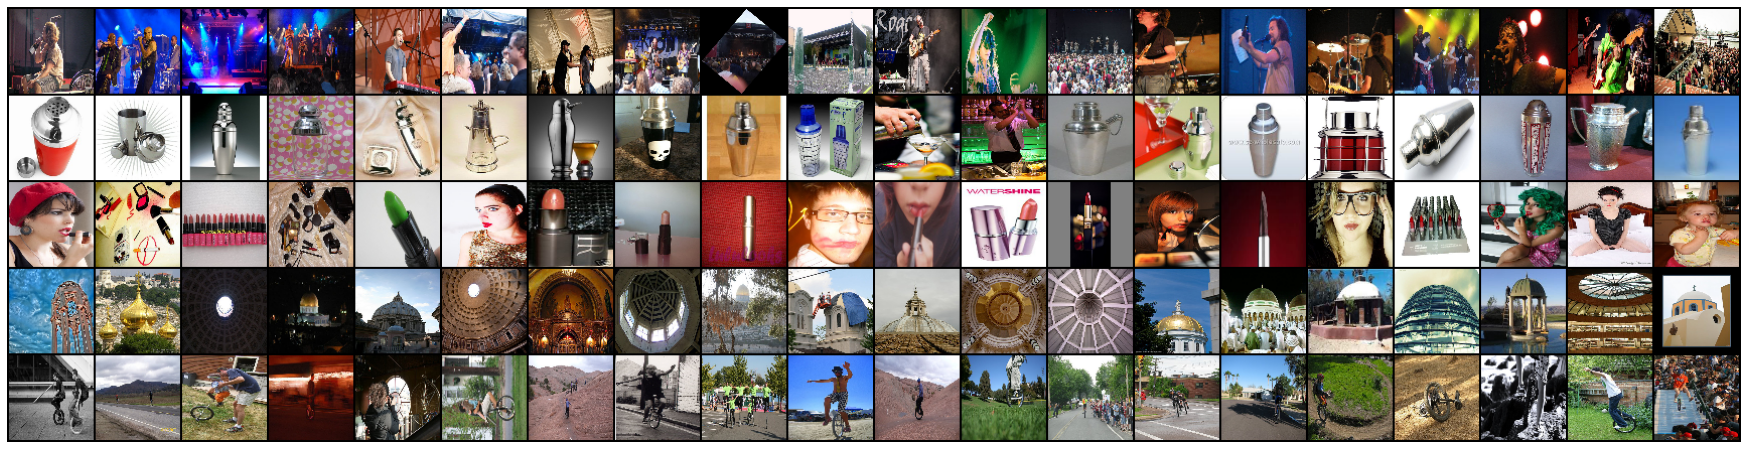

In [54]:
episode_dict = extract_episode(train_x, train_y, num_way = 5, num_shot = 5, num_query = 15)
display_episode_images(episode_dict)

#### Load trained model.

In [55]:
state_dict = torch.load(path.join(config['results_dir'], 'best_model.pth'))
model.load_state_dict(state_dict)

<All keys matched successfully>

#### Test on example.

In [57]:
_, my_output = model.set_forward_loss(episode_dict)

for item in my_output.items():
    print(item)

('loss', 0.7355508804321289)
('acc', 0.7200000286102295)
('y_hat', tensor([[4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1],
        [2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 4, 2],
        [3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1],
        [4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 0]], device='cuda:0'))
